# Augmenting and Ingesting Training Images

This notebook largely contains the following three things:
1. Finding the mean activity of all the processed training image and saving it (this step is a continuation from `preprocessing_playground.ipynb`.
2. Randomly sampling 1024 unique portions of all training images, horizontally flipping them, and returning the output (this step increases the training data by a factor of 2048, as described in the [paper](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)).
3. Principal Component Analysis of the RGB pixel values, so that the following quantity $\mathrm{[\textbf{p}_1, \, \textbf{p}_2, \, \textbf{p}_3] [\alpha_1 \lambda_1, \, \alpha_2 \lambda_2, \, \alpha_3 \lambda_3]^{T}}$ can be added to all the pixels.

The final, polished functions/code will be compiled in a separate python script where the model will be executed. 

In [1]:
import torch
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import shutil
import torchvision.transforms as transforms 
import time
from matplotlib.animation import FuncAnimation
from plotting_preferences import plotting_preferences_AS
from torchvision.transforms import v2
import torchvision.transforms.functional as F
import itertools

In [2]:
random.seed(7923478)
plotting_preferences_AS()

### Loading the processed 256 x 256 images

In [3]:
training_images_output_path = "./images/training_images_processed/"

training_images_processed_path = [
    training_images_output_path + f for f in os.listdir(training_images_output_path)
    if f.endswith('.JPEG')
]    

training_images_processed_names = [
    f for f in os.listdir(training_images_output_path)
    if f.endswith('.JPEG')
]   

print(len(training_images_processed_path))

1261405


### Ensuring all images have three channels

In [5]:
try:
    os.mkdir("./images/non_rgb_images/")
except FileExistsError:
    pass

non_rgb_images_directory = "./images/non_rgb_images/"

In [7]:
# checking the different types of non-RGB images present
# I feel there could be 2-channel images, and not just greyscales
# this ended up being not that helpful for the code below, but still interesting
print(set([Image.open(i).mode for i in training_images_processed_path if Image.open(i).mode != "RGB"]))

{'CMYK', 'L'}


In [9]:
# should be ~0.2% of the entire training set assuming the 
# subset used in preprocessing.ipynb was a representative sample
total_non_rgb = 0

for i in tqdm(training_images_processed_path):
    image = Image.open(i)
    
    if image.mode != "RGB":
        total_non_rgb += 1

        # copying the non-RGBs to another folder
        shutil.copy(i, f"./images/non_rgb_images/")

        # converting to a three channel image 
        # and saving it in-place of the old one
        three_channel_image = image.convert("RGB")
        three_channel_image.save(i)

print(f"Total non-RGB images found: {total_non_rgb}.")
print(
    f"{100 * np.round(total_non_rgb / len(training_images_processed_path), 4)}% \
    of images didn't have three channels."
)

100%|███████████████████████████████| 1261405/1261405 [04:49<00:00, 4360.37it/s]

Total non-RGB images found: 1984.
0.16%     of images didn't have three channels.


In [ ]:
# checking if all training images now have three channels
# returns an empty list
[i for i in training_images_processed_path if np.asarray(Image.open(i)).shape != (256, 256, 3)]

### Finding the mean activity of all the images and saving it

##### The methods below make the notebook crash because of the size of the dataset

In [17]:
### Method 1: from preprocessing_playground.ipynb

#mean_activity_all_images = np.mean(
#    [np.asarray(Image.open(i)) for i in training_images_processed_path],
#    axis=0
#)
#plt.imshow(np.int_(mean_activity_all_images))


### Method 2: Same as above but using torch functions

#transform = transforms.Compose([
#    transforms.PILToTensor()
#])

# stacking as a tensor and computing the mean
#all_images = torch.stack([transform(Image.open(i)) for i in training_images_processed_path])
# mean_activity_all_images = torch.mean(all_images, dim=0)

#mean_activity_image = mean_activity_all_images.numpy().astype(np.int32)
#plt.imshow(mean_activity_image.transpose(1, 2, 0))
#plt.show()

In [40]:
### Method 3: Running mean -> mean
# this method, if sound, will be memory efficient

image_shape = np.asarray(Image.open(training_images_processed_path[0])).shape

image_sums = np.zeros(image_shape)
total_count = 0

### testing with a thousand images to see if this works right
for i in training_images_processed_path[:1000]:
    one_image = np.asarray(Image.open(i))

    image_sums += one_image
    total_count += 1
    mean_activity_test = image_sums / total_count

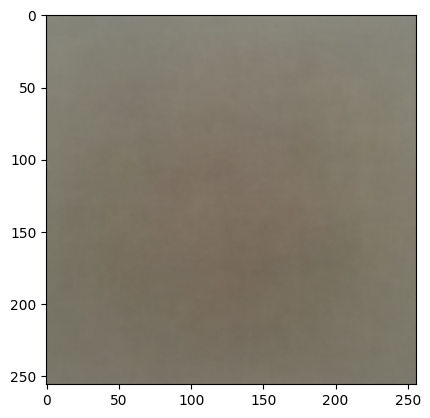

In [41]:
# Method 1 for a thousand images
mean_activity_image_sample = np.mean([np.asarray(Image.open(i)) for i in training_images_processed_path[:1000]], axis=0)
plt.imshow(np.int_(mean_activity_image_sample))

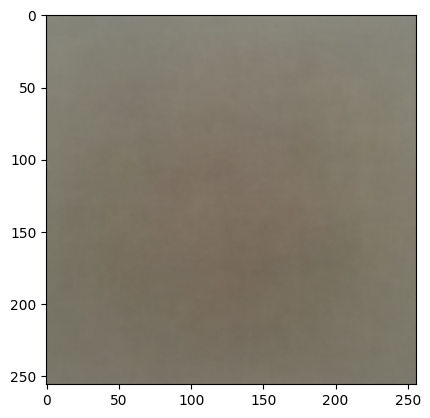

In [42]:
plt.imshow(np.int_(np.asarray(mean_activity_test)))

In [43]:
mean_activity_test == mean_activity_image_sample

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       ...,

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,

#### Running Method 3 for all training images

In [44]:
### Method 3: Running mean -> mean
# this method is memory efficient

image_shape = np.asarray(Image.open(training_images_processed_path[0])).shape

image_sums = np.zeros(image_shape)
total_count = 0

for i in tqdm(training_images_processed_path):
    one_image = np.asarray(Image.open(i))

    image_sums += one_image
    total_count += 1
    mean_activity_training = image_sums / total_count

100%|███████████████████████████████| 1261405/1261405 [14:18<00:00, 1470.09it/s]


In [45]:
# saving the mean activity/image as an array
with open("./images/mean_activity_of_all_training_images.npy", "wb") as f:
    np.save(f, mean_activity_training)

In [46]:
# also saving it as a tensor
mean_activity_training_tensor = torch.from_numpy(mean_activity_training)
torch.save(
    mean_activity_training_tensor, 
    "./images/mean_activity_of_all_training_images.pt"
)

Using multiprocessing would have saved me 5-10 minutes but the code is simple & I needn't run it again, so it is okay.

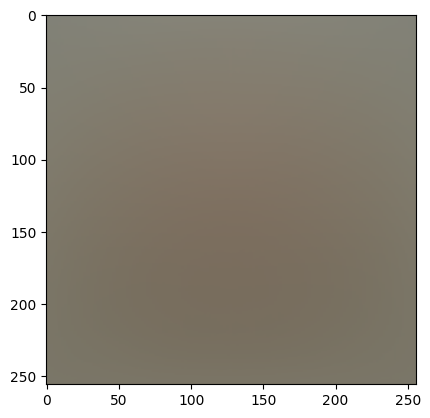

In [49]:
# visualizing the mean image of the entire training set
plt.imshow(np.int_(np.asarray(mean_activity_training)))

### Testing random sampling patches from images

In [187]:
test_image = Image.open(training_images_processed_path[0])

In [8]:
crop_transform = transforms.RandomCrop((224, 224))

Just skimming through [the source code](https://pytorch.org/vision/main/_modules/torchvision/transforms/transforms.html#RandomCrop), it seems that `transforms.RandomCrop()` doesn't sample without replacement, which is an issue because the crop size is not that different from the image size, so a non-negligible portion of cropped images would be identical. 

**While the paper doesn't talk at all about the uniqueness of the random crops,** I am assuming that the authors imposed some checks to ensure that their random crops were unique. After all, the purpose of image augmentation is to increase the diversity of training examples, but it is possible that this wasn't a major concern for the authors given the size of the training set. 

I am carrying forward with the assumption that it would be better if the crops are unique, so in the block below, I append only those cropped portions which are unique.

In [21]:
%%timeit -n1 -r1

i = 0
loop_number = []
list_length_change = []
sample_crops = []

while len(sample_crops) != 1024:
    i += 1
    loop_number.append(i)
    
    random_portion_of_image = crop_transform(test_image)
    if random_portion_of_image not in sample_crops:
        sample_crops.append(random_portion_of_image)

    list_length_change.append(len(sample_crops))

4min 20s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The block below is nearly identical as the one above, except I am using a `set()` to ensure only unique crops are saved.

In [14]:
%%timeit -n1 -r1

i = 0
loop_number = []
list_length_change = []
sample_crops = set()

while len(sample_crops) != 1024:
    i += 1
    loop_number.append(i)
    
    random_portion_of_image = crop_transform(test_image)
    random_portion_of_image_tuple = tuple(random_portion_of_image.getdata())
    
    sample_crops.add(random_portion_of_image_tuple)

    list_length_change.append(len(sample_crops))

8.26 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The set method is much faster, so running that:

In [30]:
# using set instead of list is much faster, so using that instead

i = 0
loop_number = []
list_length_change = []
sample_crops = set()

while len(sample_crops) != 1024:
    i += 1
    loop_number.append(i)
    
    random_portion_of_image = crop_transform(test_image)
    random_portion_of_image_tuple = tuple(random_portion_of_image.getdata())
    
    sample_crops.add(random_portion_of_image_tuple)

    list_length_change.append(len(sample_crops))

I saved the loops and length of the unique images in a list so that I could plot them and see how many loops it takes to sample 1024 unique 224 x 224 sized images from an original image which has the size 256 x 256.

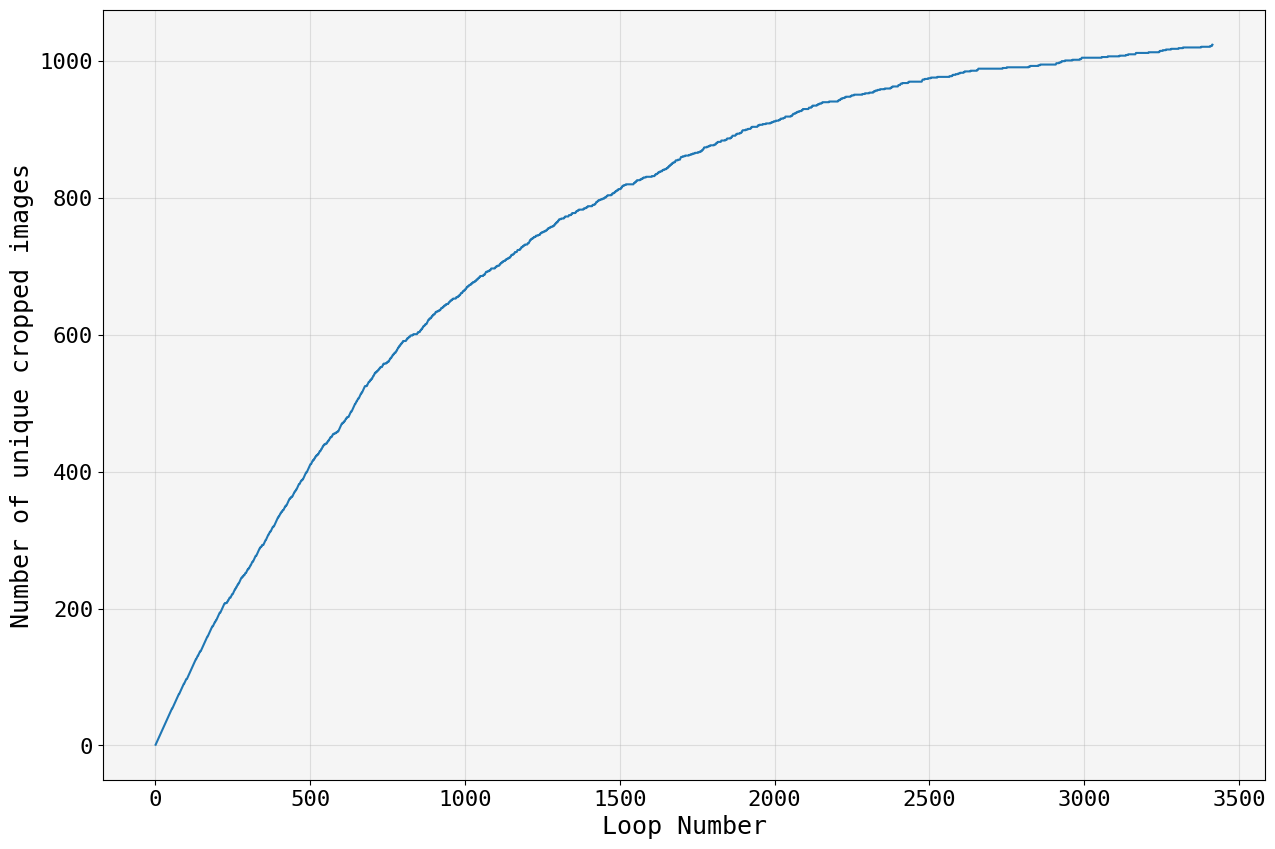

In [66]:
figure, ax = plt.subplots(figsize=(15, 10))
plt.plot(
    loop_number, 
    list_length_change
)

plt.xlabel("Loop Number")
plt.ylabel("Number of unique cropped images")

plt.grid(alpha=0.35)

plt.show()

In [15]:
def tuple_to_image(
    crop_tuple, 
    size=(224, 224)
):
    """
    This function takes the tuple of an image 
    and converts it back to an image using Pillow

    :param 
    """
    pixel_list = list(crop_tuple)
    image = Image.new('RGB', size)
    image.putdata(pixel_list)
    
    return image

In [43]:
%%timeit

sample_crops_list = list(map(tuple_to_image, list(sample_crops)))
sample_crops_list.extend([i.transpose(method=Image.FLIP_LEFT_RIGHT) for i in sample_crops_list])

1.81 s ± 8.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Tested the above using generator expressions and torch stack + flip functions and the runtime appears to be about the same (~2 seconds) on my device.

In [47]:
# now actually running it
sample_crops_list = list(
    map(tuple_to_image, list(sample_crops))
)
sample_crops_list.extend([i.transpose(method=Image.FLIP_LEFT_RIGHT) for i in sample_crops_list])

len(sample_crops_list)

2048

Next, I want to compile a function using the snippets above which takes an image as the input, randomly samples 1024 unique portions of it, flips them horizontally, and returns a list of 2048 cropped and flipped images.

The issue is that the unique random sampling thing I wrote above takes around 8 seconds to execute and the flipping routine takes around 2 seconds, so that is 10 seconds per image, and for the entire dataset, ~12 million seconds or...

In [27]:
print(f"...{(10 * 1.2 * 1e6) / (24 * 3600):.1f} days!?")

...138.9 days!?


Even after parallel processing (10x reduction in time using a 10-core CPU), the time taken would be exorbitantly high. 

Randomly sampling the images as arrays would be much more faster; I abandoned this initially with the hopes that direct image cropping, given its simplicity, would work. If sampling with replacement was fine, then it would have been much easier!

In [6]:
%%timeit

sample_crops_list = [crop_transform(test_image) for _ in range(1024)]
sample_crops_list.extend([i.transpose(method=Image.FLIP_LEFT_RIGHT) for i in sample_crops_list])

70 ms ± 3.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
### Didn't expect much to change below
### just adding the flipped images at once
### performs worse...I thought it would be still ~10 seconds

#%%timeit -n1 -r1

#sample_crops = set()

#while len(sample_crops) != 2048:
#    random_portion_of_image = crop_transform(test_image)
#    random_portion_of_image_flipped = random_portion_of_image.transpose(method=Image.FLIP_LEFT_RIGHT)
    
#    random_portion_of_image_tuple = tuple(random_portion_of_image.getdata())
#    random_portion_of_image_flipped_tuple = tuple(random_portion_of_image_flipped.getdata())
    
#    sample_crops.add(random_portion_of_image_tuple)
#    sample_crops.add(random_portion_of_image_flipped_tuple)

15.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### Randomly sampling images as arrays

In [9]:
test_image = Image.open(training_images_processed_path[0])

In [10]:
np.asarray(test_image)[:, :, 1]

array([[ 7,  7,  7, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 2,  2,  3, ...,  5,  5,  5],
       ...,
       [22, 24, 24, ..., 14, 12, 11],
       [21, 22, 23, ..., 15, 14, 12],
       [16, 17, 18, ..., 11, 10,  8]], dtype=uint8)

In [11]:
# total possible 224 x 244 random crops from a 256 x 256 sized image
(256 - 224 + 1) ** 2

1089

In [12]:
# getting all possible left-top corners for 224 x 224 sized patches
left_top_corners = [p for p in itertools.product(range(256 - 224 + 1), repeat=2)]

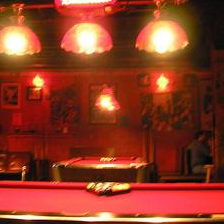

In [13]:
# checking how this method works and visualizing sampled portions
# I timed this, and the average run time is < 50 ms for one image
random_corners = random.sample(left_top_corners, 1024)

### first did it using arrays, later converted to tensors
#Image.fromarray(
#    [np.asarray(test_image)[i:i + 224, j:j+224, :] for i, j in random_corners][1]
#)


# slicing differently because numpy arrays are arranged as (height, width, channels)
# while tensors are arranged as (channels, height, width)
F.to_pil_image(
    [F.pil_to_tensor(test_image)[:, i:i + 224, j:j+224] for i, j in random_corners][1]
)

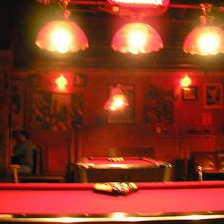

In [14]:
# horizontally flipping the cropped image

### first did it using arrays, later converted to tensors
#Image.fromarray(
#    np.flip([np.asarray(test_image)[i:i + 224, j:j+224, :] for i, j in random_corners][1], 1)
#)

F.to_pil_image(
    torch.flip(
        [F.pil_to_tensor(test_image)[:, i:i + 224, j:j+224] for i, j in random_corners][1], 
        dims=(2,) # the 1st dimension of a numpy array is the 2nd one in a tensor
    )
)

In [15]:
### took a subset to test run the mapping of the function "extract_image_portions"
#training_images_processed_path_subset = training_images_processed_path[:1200]

In [16]:
%%timeit # -r1 -n1

def extract_image_portions(
    image_path, 
):
    random_corners = random.sample(left_top_corners, 1024)

    ### used numpy arrays initially, and tensors later
    #image_portions = [np.asarray(Image.open(image))[i:i + 224, j:j+224, :] for i, j in random_corners] 
    #return image_portions
    
    image_as_tensor = F.pil_to_tensor(Image.open(image_path))
    image_portions = [image_as_tensor[:, i:i + 224, j:j+224] for i, j in random_corners] 
    image_portions.extend(
        [torch.flip(i, dims=(2,)) for i in image_portions]
    )
    
    return image_portions

many_image_portions = map(extract_image_portions, training_images_processed_path)

76.8 ns ± 0.688 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


**The method above seems suspiciously fast; 1024 randomly selected image portions for 1.2 million images in nanoseconds?!**

Running the code for real (timeit causes issues because of how [local variables are re-assigned](https://stackoverflow.com/questions/54922775/using-magic-command-timeit-n1-r1-causes-jupyter-does-not-keep-the-value-of), and visualizing the output below; the results seem sound.

In [4]:
left_top_corners = [p for p in itertools.product(range(256 - 224 + 1), repeat=2)]

def extract_image_portions(
    image_path,
    left_top_corners=left_top_corners
):
    """
    This function randomly crops 1024 unique 224x224 sized portions of the input image, 
    horizontally flips them, and returns a list containing 2048 images as PyTorch tensors.

    This function can be generalized further to crop N x N portions, or randomly sample D
    amount of top-left corners.
    """
    random_corners = random.sample(left_top_corners, 1024)
    
    image_as_tensor = F.pil_to_tensor(Image.open(image_path))
    image_portions = [image_as_tensor[:, i:i + 224, j:j+224] for i, j in random_corners] 
    image_portions.extend(
        [torch.flip(i, dims=(2,)) for i in image_portions]
    )

    return image_portions

# mapping the function to the entire training set
many_image_portions = map(extract_image_portions, training_images_processed_path)

# creating an iter object of all the image paths
iter_processed_training_images = iter(training_images_processed_path)

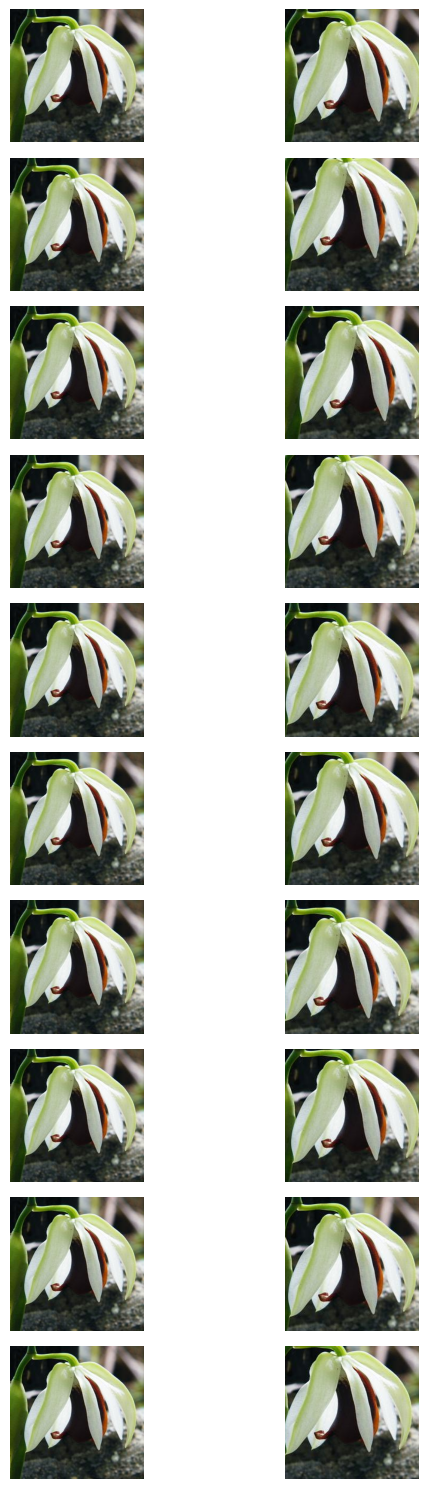

In [197]:
# recycling this code from preprocessing_playground.ipynb 
# some changes within zip()

images_to_show = 10

fig, ax = plt.subplots(images_to_show, 2, figsize=(20, 15))

for n, original_image, transformed_image in zip(
    range(images_to_show),
    [next(iter_processed_training_images)] * images_to_show, 
    list(next(many_image_portions))[:images_to_show],
):
    ax[n, 0].imshow(Image.open(original_image))
    ax[n, 1].imshow(F.to_pil_image(transformed_image))
    
    ax[n, 0].axis('off')
    ax[n, 1].axis('off')

plt.subplots_adjust(wspace=-1, hspace=0) 
plt.tight_layout()
plt.show()

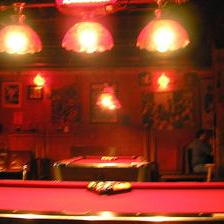

In [201]:
### double checking that the images are flipped properly

test_image_crops_and_flips = extract_image_portions(training_images_processed_path[0])
F.to_pil_image(test_image_crops_and_flips[0])

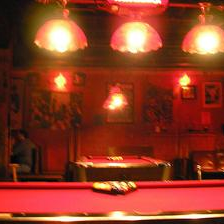

In [203]:
F.to_pil_image(test_image_crops_and_flips[1024])

In hindsight, I got too anchored by the first approach and trying to make it work and finding ways to shave off a few seconds, when I should have abandoned it after the third try. To be fair, I was imagining some very complex array slicing for 1.2 million images and not simply sampling the left-top image coordinates.  

## Principal Component Analysis (PCA) of RGB Pixel Values

In [ ]:
list(map(extract_image_portions, training_images_processed_path[:12000]))[0]